# This model offers a comparison between my model and another model using pytorch - some improvement in accuracy of predicting classes with this model.  Source: https://towardsdatascience.com/using-deep-learning-for-end-to-end-multiclass-text-classification-39b46aecac81


## IMPORTS 

In [1]:
import random
import copy
import time
import pandas as pd
import numpy as np
import gc
import re
import torch

#import spacy
from tqdm import tqdm_notebook, tnrange
from tqdm.auto import tqdm

tqdm.pandas(desc='Progress')
from collections import Counter

from nltk import word_tokenize

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from torch.autograd import Variable
from sklearn.metrics import f1_score
import os 

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

# cross validation and metrics
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score
from torch.optim.optimizer import Optimizer

from sklearn.preprocessing import StandardScaler
from multiprocessing import  Pool
from functools import partial
import numpy as np
from sklearn.decomposition import PCA
import torch as t
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt


/home/kysha/anaconda3/envs/kyshacuda/lib/python3.7/site-packages/tqdm/std.py:668: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


### Basic Parameters

In [2]:
embed_size = 300 # how big is each word vector
max_features = 120000 # how many unique words to use (i.e num rows in embedding vector)
maxlen = 750 # max number of words in a question to use
batch_size = 512 # how many samples to process at once
n_epochs = 5 # how many times to iterate over all samples
n_splits = 5 # Number of K-fold Splits
SEED = 10
debug = 0

In [3]:
data_1=pd.read_csv('occ_categories_nouns_only.csv')

In [4]:
data = data_1[['occ_group','job_description']]

In [5]:
# remove NULL Values from data
data = data[pd.notnull(data['job_description'])]

## Finding the maxlen

In [6]:
data['len'] = data['job_description'].apply(lambda s : len(s))

<AxesSubplot:ylabel='Frequency'>

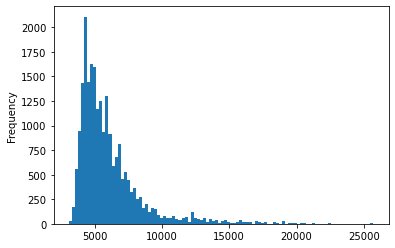

In [7]:
data['len'].plot.hist(bins=100)

In [8]:
data.len.quantile(0.9)

8640.0

## Preprocessing Y Column
We are only going to be classifying conditions for which the count of reviews are more than 3000.

In [9]:
count_df = data[['occ_group','job_description']].groupby('occ_group').aggregate({'job_description':'count'}).reset_index().sort_values('job_description',ascending=False)
count_df.head()

,occ_group,job_description
5,technical,5837
0,basic,4889
3,social,4500
2,resource management,3753
4,systems,2341


In [55]:
target_conditions = count_df[count_df['job_description']>300]['occ_group'].values

In [56]:
target_conditions

array(['technical', 'basic', 'social', 'resource management', 'systems',
       'complex problem solving'], dtype=object)

In [12]:
def condition_parser(x):
    if x in target_conditions:
        return x
    else:
        return "OTHER"
    
'''data['condition'] = data['condition'].apply(lambda x: condition_parser(x))  
data = data[data['skill_category']!='OTHER']'''

"data['condition'] = data['condition'].apply(lambda x: condition_parser(x))  \ndata = data[data['skill_category']!='OTHER']"

In [13]:
import plotly.express as px

In [54]:
px.bar(count_df[count_df['job_description']>300],x='occ_group',y='job_description')

In [15]:
import re

def clean_text(x):
    pattern = r'[^a-zA-z0-9\s]'
    text = re.sub(pattern, '', x)
    return x

def clean_numbers(x):
    if bool(re.search(r'\d', x)):
        x = re.sub('[0-9]{5,}', '#####', x)
        x = re.sub('[0-9]{4}', '####', x)
        x = re.sub('[0-9]{3}', '###', x)
        x = re.sub('[0-9]{2}', '##', x)
    return x

In [16]:
contraction_dict = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not", "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",  "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would", "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would", "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as", "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would", "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",  "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have", "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have","you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have"}
def _get_contractions(contraction_dict):
    contraction_re = re.compile('(%s)' % '|'.join(contraction_dict.keys()))
    return contraction_dict, contraction_re
contractions, contractions_re = _get_contractions(contraction_dict)
def replace_contractions(text):
    def replace(match):
        return contractions[match.group(0)]
    return contractions_re.sub(replace, text)
# Usage
replace_contractions("this's a text with contraction")

'this is a text with contraction'

In [17]:
# lower the text
data["job_description"] = data["job_description"].apply(lambda x: x.lower())

# Clean the text
data["job_description"] = data["job_description"].apply(lambda x: clean_text(x))

# Clean numbers
data["job_description"] = data["job_description"].apply(lambda x: clean_numbers(x))

# Clean Contractions
data["job_description"] = data["job_description"].apply(lambda x: replace_contractions(x))


In [19]:
data=data.fillna('None')

In [21]:
data=data[data['occ_group']!='None']

In [22]:
data['occ_group']

0        basic
1        basic
2        basic
3        basic
4        basic
         ...  
22266    basic
22267    basic
22268    basic
22269    basic
22270    basic
Name: occ_group, Length: 22271, dtype: object

In [23]:
from sklearn.model_selection import train_test_split
train_X, test_X, train_y, test_y = train_test_split(data['job_description'], data['occ_group'],
                                                    stratify=data['occ_group'], 
                                                    test_size=0.25)

In [24]:
print("Train shape : ",train_X.shape)
print("Test shape : ",test_X.shape)

Train shape :  (16703,)
Test shape :  (5568,)


In [25]:
## Tokenize the sentences
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(train_X))
train_X = tokenizer.texts_to_sequences(train_X)
test_X = tokenizer.texts_to_sequences(test_X)

## Pad the sentences 
train_X = pad_sequences(train_X, maxlen=maxlen)
test_X = pad_sequences(test_X, maxlen=maxlen)

In [26]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
train_y = le.fit_transform(train_y.values)
test_y = le.transform(test_y.values)

In [27]:
le.classes_

array(['basic', 'complex problem solving', 'resource management',
       'social', 'systems', 'technical'], dtype=object)

### Load Embeddings


In [28]:
## FUNCTIONS TAKEN FROM https://www.kaggle.com/gmhost/gru-capsule

def load_glove(word_index):
    EMBEDDING_FILE = 'glove.6B/glove.6B.300d.txt'
    def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')[:300]
    embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(EMBEDDING_FILE))
    
    all_embs = np.stack(embeddings_index.values())
    emb_mean,emb_std = -0.005838499,0.48782197
    embed_size = all_embs.shape[1]

    nb_words = min(max_features, len(word_index)+1)
    embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
    for word, i in word_index.items():
        if i >= max_features: continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None: 
            embedding_matrix[i] = embedding_vector
        else:
            embedding_vector = embeddings_index.get(word.capitalize())
            if embedding_vector is not None: 
                embedding_matrix[i] = embedding_vector
    return embedding_matrix

In [29]:
# missing entries in the embedding are set using np.random.normal so we have to seed here too

if debug:
    embedding_matrix = np.random.randn(120000,300)
else:
    embedding_matrix = load_glove(tokenizer.word_index)

/home/kysha/anaconda3/envs/kyshacuda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3417: FutureWarning:

arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.



In [30]:
np.shape(embedding_matrix)

(49048, 300)

## Pytorch Model - TextCNN

In [28]:
class CNN_Text(nn.Module):
    
    def __init__(self):
        super(CNN_Text, self).__init__()
        filter_sizes = [1,2,3,5]
        num_filters = 36
        n_classes = len(le.classes_)
        self.embedding = nn.Embedding(max_features, embed_size)
        self.embedding.weight = nn.Parameter(torch.tensor(embedding_matrix, dtype=torch.float32))
        self.embedding.weight.requires_grad = False
        self.convs1 = nn.ModuleList([nn.Conv2d(1, num_filters, (K, embed_size)) for K in filter_sizes])
        self.dropout = nn.Dropout(0.1)
        self.fc1 = nn.Linear(len(filter_sizes)*num_filters, n_classes)


    def forward(self, x):
        x = self.embedding(x)  
        x = x.unsqueeze(1)  
        x = [F.relu(conv(x)).squeeze(3) for conv in self.convs1] 
        x = [F.max_pool1d(i, i.size(2)).squeeze(2) for i in x]  
        x = torch.cat(x, 1)
        x = self.dropout(x)  
        logit = self.fc1(x) 
        return logit

## Train TextCNN Model

In [31]:
n_epochs = 6
model = CNN_Text()
loss_fn = nn.CrossEntropyLoss(reduction='sum')
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)
model.cuda()

# Load train and test in CUDA Memory
x_train = torch.tensor(train_X, dtype=torch.long).cuda()
y_train = torch.tensor(train_y, dtype=torch.long).cuda()
x_cv = torch.tensor(test_X, dtype=torch.long).cuda()
y_cv = torch.tensor(test_y, dtype=torch.long).cuda()

# Create Torch datasets
train = torch.utils.data.TensorDataset(x_train, y_train)
valid = torch.utils.data.TensorDataset(x_cv, y_cv)

# Create Data Loaders
train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid, batch_size=batch_size, shuffle=False)

train_loss = []
valid_loss = []

for epoch in range(n_epochs):
    start_time = time.time()
    # Set model to train configuration
    model.train()
    avg_loss = 0.  
    for i, (x_batch, y_batch) in enumerate(train_loader):
        # Predict/Forward Pass
        y_pred = model(x_batch)
        # Compute loss
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        avg_loss += loss.item() / len(train_loader)
    
    # Set model to validation configuration -Doesn't get trained here
    model.eval()        
    avg_val_loss = 0.
    val_preds = np.zeros((len(x_cv),len(le.classes_)))
    
    for i, (x_batch, y_batch) in enumerate(valid_loader):
        y_pred = model(x_batch).detach()
        avg_val_loss += loss_fn(y_pred, y_batch).item() / len(valid_loader)
        # keep/store predictions
        val_preds[i * batch_size:(i+1) * batch_size] =F.softmax(y_pred).cpu().numpy()
    
    # Check Accuracy
    val_accuracy = sum(val_preds.argmax(axis=1)==test_y)/len(test_y)
    train_loss.append(avg_loss)
    valid_loss.append(avg_val_loss)
    elapsed_time = time.time() - start_time 
    print('Epoch {}/{} \t loss={:.4f} \t val_loss={:.4f}  \t val_acc={:.4f}  \t time={:.2f}s'.format(
                epoch + 1, n_epochs, avg_loss, avg_val_loss, val_accuracy, elapsed_time))

/home/kysha/anaconda3/envs/kyshacuda/lib/python3.7/site-packages/ipykernel_launcher.py:48: UserWarning:

Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.



Epoch 1/6 	 loss=830.3371 	 val_loss=718.8850  	 val_acc=0.4173  	 time=24.31s
Epoch 2/6 	 loss=733.8850 	 val_loss=672.9980  	 val_acc=0.4441  	 time=23.97s
Epoch 3/6 	 loss=689.1014 	 val_loss=645.6269  	 val_acc=0.4773  	 time=24.12s
Epoch 4/6 	 loss=655.5776 	 val_loss=628.5886  	 val_acc=0.4894  	 time=24.16s
Epoch 5/6 	 loss=627.2790 	 val_loss=620.8490  	 val_acc=0.4796  	 time=24.12s
Epoch 6/6 	 loss=606.7257 	 val_loss=607.6407  	 val_acc=0.4856  	 time=24.11s


In [32]:
torch.save(model,'textcnn_model2')

/home/kysha/anaconda3/envs/kyshacuda/lib/python3.7/site-packages/torch/serialization.py:360: UserWarning:

Couldn't retrieve source code for container of type CNN_Text. It won't be checked for correctness upon loading.



In [40]:
def plot_graph(epochs):
    fig = plt.figure(figsize=(12,12))
    plt.title("Train/Validation Loss")
    plt.plot(list(np.arange(epochs) + 1) , train_loss, label='train')
    plt.plot(list(np.arange(epochs) + 1), valid_loss, label='validation')
    plt.xlabel('num_epochs', fontsize=12)
    plt.ylabel('loss', fontsize=12)
    plt.legend(loc='best')

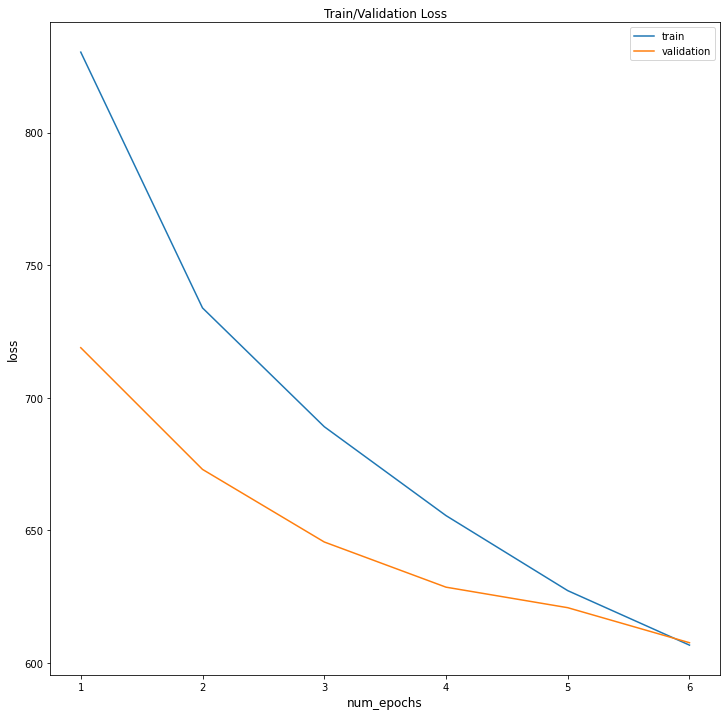

In [34]:
plot_graph(n_epochs)

<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

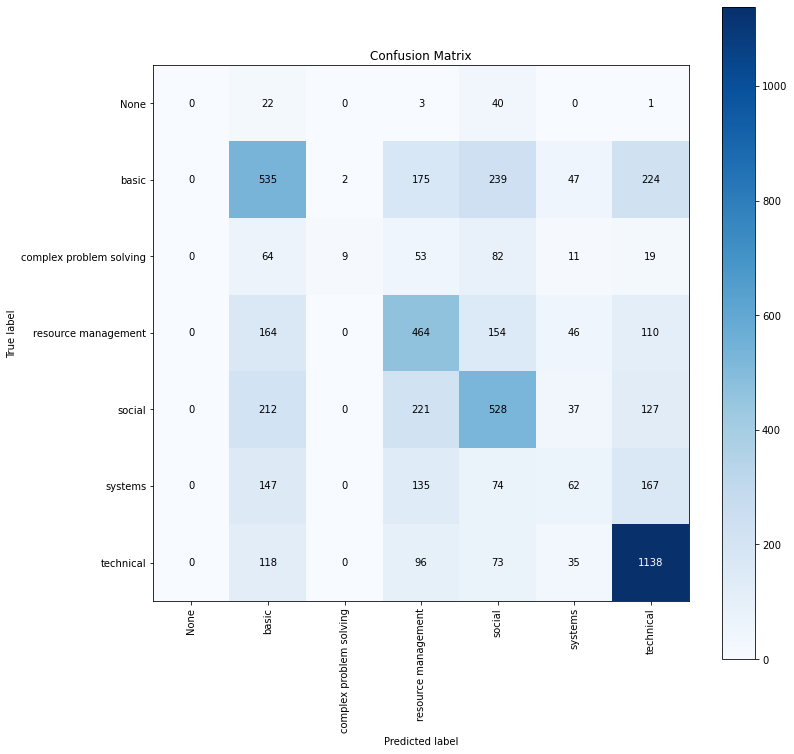

In [35]:
import scikitplot as skplt
y_true = [le.classes_[x] for x in test_y]
y_pred = [le.classes_[x] for x in val_preds.argmax(axis=1)]
skplt.metrics.plot_confusion_matrix(
    y_true, 
    y_pred,
    figsize=(12,12),x_tick_rotation=90)

## Pytorch Model - BiLSTM

In [31]:
class BiLSTM(nn.Module):
    
    def __init__(self):
        super(BiLSTM, self).__init__()
        self.hidden_size = 64
        drp = 0.1
        n_classes = len(le.classes_)
        self.embedding = nn.Embedding(max_features, embed_size)
        self.embedding.weight = nn.Parameter(torch.tensor(embedding_matrix, dtype=torch.float32))
        self.embedding.weight.requires_grad = False
        self.lstm = nn.LSTM(embed_size, self.hidden_size, bidirectional=True, batch_first=True)
        self.linear = nn.Linear(self.hidden_size*4 , 64)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(drp)
        self.out = nn.Linear(64, n_classes)


    def forward(self, x):
        #rint(x.size())
        h_embedding = self.embedding(x)
        #_embedding = torch.squeeze(torch.unsqueeze(h_embedding, 0))
        h_lstm, _ = self.lstm(h_embedding)
        avg_pool = torch.mean(h_lstm, 1)
        max_pool, _ = torch.max(h_lstm, 1)
        conc = torch.cat(( avg_pool, max_pool), 1)
        conc = self.relu(self.linear(conc))
        conc = self.dropout(conc)
        out = self.out(conc)
        return out

In [32]:
n_epochs = 6
model = BiLSTM()
loss_fn = nn.CrossEntropyLoss(reduction='sum')
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)
model.cuda()

BiLSTM(
  (embedding): Embedding(120000, 300)
  (lstm): LSTM(300, 64, batch_first=True, bidirectional=True)
  (linear): Linear(in_features=256, out_features=64, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.1, inplace=False)
  (out): Linear(in_features=64, out_features=6, bias=True)
)

In [33]:
# Load train and test in CUDA Memory
x_train = torch.tensor(train_X, dtype=torch.long).cuda()
y_train = torch.tensor(train_y, dtype=torch.long).cuda()
x_cv = torch.tensor(test_X, dtype=torch.long).cuda()
y_cv = torch.tensor(test_y, dtype=torch.long).cuda()

In [34]:
# Create Torch datasets
train = torch.utils.data.TensorDataset(x_train, y_train)
valid = torch.utils.data.TensorDataset(x_cv, y_cv)


In [35]:
# Create Data Loaders
train_loader = torch.utils.data.DataLoader(train, batch_size=80, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid, batch_size=80, shuffle=False)


In [37]:
batch_size

512

In [38]:
train_loss = []
valid_loss = []

for epoch in range(n_epochs):
    start_time = time.time()
    # Set model to train configuration
    model.train()
    avg_loss = 0.  
    for i, (x_batch, y_batch) in enumerate(train_loader):
        # Predict/Forward Pass
        y_pred = model(x_batch)
        # Compute loss
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        avg_loss += loss.item() / len(train_loader)
    
    # Set model to validation configuration -Doesn't get trained here
    model.eval()        
    avg_val_loss = 0.
    val_preds = np.zeros((len(x_cv),len(le.classes_)))
    
    for i, (x_batch, y_batch) in enumerate(valid_loader):
        y_pred = model(x_batch).detach()
        avg_val_loss += loss_fn(y_pred, y_batch).item() / len(valid_loader)
        # keep/store predictions
        val_preds[i * 80:(i+1) * 80] =F.softmax(y_pred).cpu().numpy()
    
    # Check Accuracy
    val_accuracy = sum(val_preds.argmax(axis=1)==test_y)/len(test_y)
    train_loss.append(avg_loss)
    valid_loss.append(avg_val_loss)
    elapsed_time = time.time() - start_time 
    print('Epoch {}/{} \t loss={:.4f} \t val_loss={:.4f}  \t val_acc={:.4f}  \t time={:.2f}s'.format(
                epoch + 1, n_epochs, avg_loss, avg_val_loss, val_accuracy, elapsed_time))

/home/kysha/anaconda3/envs/kyshacuda/lib/python3.7/site-packages/ipykernel_launcher.py:28: UserWarning:

Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.



Epoch 1/6 	 loss=125.3281 	 val_loss=117.7942  	 val_acc=0.3980  	 time=19.08s
Epoch 2/6 	 loss=114.9178 	 val_loss=110.2960  	 val_acc=0.4441  	 time=18.29s
Epoch 3/6 	 loss=107.4253 	 val_loss=105.3950  	 val_acc=0.4864  	 time=18.21s
Epoch 4/6 	 loss=101.1893 	 val_loss=102.5339  	 val_acc=0.4921  	 time=18.30s
Epoch 5/6 	 loss=95.5645 	 val_loss=100.4275  	 val_acc=0.4982  	 time=18.30s
Epoch 6/6 	 loss=90.7005 	 val_loss=99.8356  	 val_acc=0.5013  	 time=18.37s


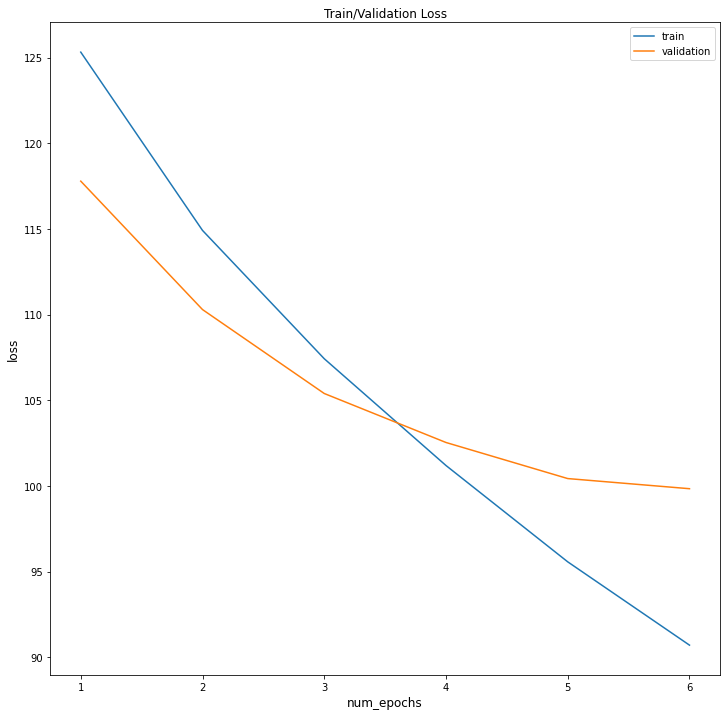

In [41]:
plot_graph(n_epochs)

In [42]:
torch.save(model,'bilstm_model')

/home/kysha/anaconda3/envs/kyshacuda/lib/python3.7/site-packages/torch/serialization.py:360: UserWarning:

Couldn't retrieve source code for container of type BiLSTM. It won't be checked for correctness upon loading.



<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

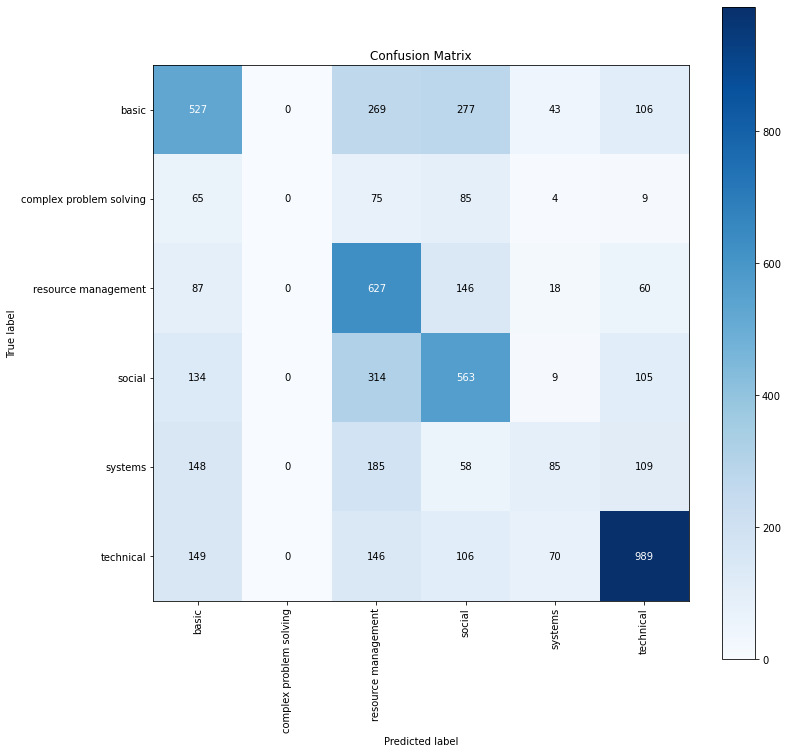

In [43]:
import scikitplot as skplt
y_true = [le.classes_[x] for x in test_y]
y_pred = [le.classes_[x] for x in val_preds.argmax(axis=1)]
skplt.metrics.plot_confusion_matrix(
    y_true, 
    y_pred,
    figsize=(12,12),x_tick_rotation=90)

## Deploy : Predict A Single Example

In [44]:
def predict_single(x):    
    # lower the text
    x = x.lower()
    # Clean the text
    x =  clean_text(x)
    # Clean numbers
    x =  clean_numbers(x)
    # Clean Contractions
    x = replace_contractions(x)
    # tokenize
    x = tokenizer.texts_to_sequences([x])
    # pad
    x = pad_sequences(x, maxlen=maxlen)
    # create dataset
    x = torch.tensor(x, dtype=torch.long).cuda()

    pred = model(x).detach()
    pred = F.softmax(pred).cpu().numpy()

    pred = pred.argmax(axis=1)

    pred = le.classes_[pred]
    return pred[0]

In [45]:
x = data['job_description'].values[20]
print(x)

who we are 
headquartered in los angeles with additional offices in west des moines, ia and hanover, md, docupace is a technology company built for the financial services and wealth management industry. for over ## years, we’ve dedicated our resources to solving the most frustrating and time-consuming problems that advisors, broker-dealers, and rias face on a daily basis. our team is built from a diverse set of talents: software developers, technology leaders, compliance and security specialists, mathematicians, management experts, financial professionals, client services geniuses—they all come together to make us the leading universal workflow and document management automation software choice for financial service and wealth management firms and their advisors everywhere. 
 
by eliminating transactional paperwork and its associated costs, we make work easier for financial services professionals, and increase profit for their firms. our cloud-based, end-to-end software solution contai

In [46]:
predict_single(x)

/home/kysha/anaconda3/envs/kyshacuda/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning:

Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.



'social'

In [48]:
data['occ_group'].iloc[20]

'basic'